# Xây dựng mô hình CNN phân loại âm thanh tim và phổi

## 1. Khai báo thư viện

In [2]:
# Import thư viện cơ bản cho xử lý dữ liệu và hệ thống
import os  
import random  
import warnings  
from pathlib import Path  

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  

# Import thư viện âm thanh
import wave  
import librosa  
import librosa.display  

# Import TensorFlow / Keras
import tensorflow as tf  
from tensorflow.keras import layers, models 
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.applications import MobileNetV2  
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.preprocessing.image import load_img, img_to_array  

# Import sklearn
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix, classification_report 

warnings.filterwarnings('ignore')  # Tắt cảnh báo không cần thiết để notebook gọn

# Thiết lập random seed để tái lập kết quả
SEED = 42  # Giá trị seed cố định
random.seed(SEED)  # Seed cho thư viện random
np.random.seed(SEED)  # Seed cho numpy
tf.random.set_seed(SEED)  # Seed cho tensorflow

print('Đã import thư viện và thiết lập seed thành công.')  # Thông báo hoàn tất

Đã import thư viện và thiết lập seed thành công.


## 2. Chuẩn bị đường dẫn dữ liệu

In [3]:
# Gợi ý: bạn chỉnh lại thư mục dữ liệu gốc cho đúng máy của bạn
thu_muc_du_lieu = Path(r'Dataset.v2')  

# Đường dẫn WAV
duong_dan_hs_wav = thu_muc_du_lieu / 'HS' / 'HS'  
duong_dan_ls_wav = thu_muc_du_lieu / 'LS' / 'LS'  

# Đường dẫn CSV
duong_dan_hs_csv = thu_muc_du_lieu / 'HS.csv' 
duong_dan_ls_csv = thu_muc_du_lieu / 'LS.csv'  

print('Thư mục dữ liệu:', thu_muc_du_lieu.resolve())  
print('HS wav:', duong_dan_hs_wav)  
print('LS wav:', duong_dan_ls_wav)  
print('HS csv:', duong_dan_hs_csv)  
print('LS csv:', duong_dan_ls_csv)  

Thư mục dữ liệu: D:\Mon_hoc\KPDL\BaoCaoMonHoc\Dataset.v2
HS wav: Dataset.v2\HS\HS
LS wav: Dataset.v2\LS\LS
HS csv: Dataset.v2\HS.csv
LS csv: Dataset.v2\LS.csv


## 3. Đọc CSV và kiểm tra EDA


In [4]:
# Đọc HS.csv và LS.csv
du_lieu_hs = pd.read_csv(duong_dan_hs_csv) 
du_lieu_ls = pd.read_csv(duong_dan_ls_csv)  

print('HS.csv - 5 dòng đầu:') 
display(du_lieu_hs.head())  
print('\nThông tin tổng quan HS.csv:')  
du_lieu_hs.info()  

print('\nLS.csv - 5 dòng đầu:') 
display(du_lieu_ls.head())  
print('\nThông tin tổng quan LS.csv:')  
du_lieu_ls.info()  

HS.csv - 5 dòng đầu:


,Gender,Heart Sound Type,Location,Heart Sound ID
0,F,Normal,RC,F_N_RC
1,F,Normal,LC,F_N_LC
2,M,Normal,RUSB,M_N_RUSB
3,F,Normal,LUSB,F_N_LUSB
4,F,Normal,LLSB,F_N_LLSB



Thông tin tổng quan HS.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Gender            50 non-null     object
 1   Heart Sound Type  50 non-null     object
 2   Location          50 non-null     object
 3   Heart Sound ID    50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB

LS.csv - 5 dòng đầu:


,Gender,Lung Sound Type,Location,Lung Sound ID
0,M,Normal,RUA,M_N_RUA
1,F,Normal,LUA,F_N_LUA
2,F,Normal,RMA,F_N_RMA
3,F,Normal,LMA,F_N_LMA
4,M,Normal,RLA,M_N_RLA



Thông tin tổng quan LS.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           50 non-null     object
 1   Lung Sound Type  50 non-null     object
 2   Location         50 non-null     object
 3   Lung Sound ID    50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


In [5]:
# Kiểm tra số lượng file WAV trong thư mục HS và LS
so_wav_hs = len(list(duong_dan_hs_wav.glob('*.wav'))) if duong_dan_hs_wav.exists() else 0  
so_wav_ls = len(list(duong_dan_ls_wav.glob('*.wav'))) if duong_dan_ls_wav.exists() else 0  

print('Số file WAV HS:', so_wav_hs)  
print('Số file WAV LS:', so_wav_ls)  

Số file WAV HS: 50
Số file WAV LS: 50


In [6]:
# Thống kê bệnh & vị trí
print('Bảng chéo HS (bệnh - vị trí):')
bang_cheo_hs = pd.crosstab(du_lieu_hs['Heart Sound Type'], du_lieu_hs['Location'])
display(bang_cheo_hs)

print('\nBảng chéo LS (bệnh - vị trí):')
bang_cheo_ls = pd.crosstab(du_lieu_ls['Lung Sound Type'], du_lieu_ls['Location'])
display(bang_cheo_ls)


Bảng chéo HS (bệnh - vị trí):


Location,Apex,LC,LLSB,LUSB,RC,RUSB
Heart Sound Type,,,,,,
AV Block,1,0,1,0,1,0
Atrial Fibrillation,1,1,0,1,0,1
Early Systolic Murmur,1,0,1,2,0,2
Late Diastolic Murmur,1,1,2,2,0,0
Late Systolic Murmur,1,0,1,2,0,1
Mid Systolic Murmur,2,0,1,2,1,1
Normal,1,2,2,1,1,2
S3,1,1,2,1,0,0
S4,0,0,0,1,1,0



Bảng chéo LS (bệnh - vị trí):


Location,LLA,LMA,LUA,RLA,RMA,RUA
Lung Sound Type,,,,,,
Coarse Crackles,2,2,2,2,1,0
Fine Crackles,0,0,2,2,0,1
Normal,2,2,2,2,2,2
Pleural Rub,2,2,2,1,1,1
Rhonchi,1,2,2,2,0,1
Wheezing,1,1,1,1,1,2


| Loại âm tim                 | Giải thích ngắn gọn        | Đặc điểm âm thanh khi nghe                   |
| --------------------------- | -------------------------- | -------------------------------------------- |
| **Normal**                  | Tim khỏe mạnh              | Nhịp đều, rõ **“lub – dub”**, không âm lạ    |
| **Late Diastolic Murmur**   | Tiếng thổi cuối thì giãn   | Âm **xì xào nhẹ**, xuất hiện **trước “lub”** |
| **Mid Systolic Murmur**     | Tiếng thổi giữa thì co bóp | Âm **gió thổi**, mạnh dần rồi yếu            |
| **Late Systolic Murmur**    | Tiếng thổi cuối thì co bóp | Âm kéo dài, rõ **sát “dub”**                 |
| **Early Systolic Murmur**   | Tiếng thổi đầu thì co bóp  | Âm thổi **xuất hiện sớm**, ngắn              |
| **Atrial Fibrillation**     | Rung nhĩ – nhịp tim loạn   | Nhịp **không đều**, lúc nhanh lúc chậm       |
| **S3 (Third Heart Sound)**  | Tiếng tim thứ 3            | Âm **trầm, ngắn**, nghe *lub–dub–thump*      |
| **S4 (Fourth Heart Sound)** | Tiếng tim thứ 4            | Âm trầm **trước “lub”**, như gõ nhẹ          |
| **Tachycardia**             | Tim đập nhanh              | Nhịp **dồn dập**, khó tách lub–dub           |
| **AV Block**                | Blốc dẫn truyền tim        | Nhịp **chậm / rớt nhịp**, không đều          |

==============================================================================

| Ký hiệu  | Vị trí trên cơ thể | Giải thích dễ hiểu                         |
| -------- | ------------------ | ------------------------------------------ |
| **RC**   | Sườn phải          | Nghe tim ở **bên phải lồng ngực**          |
| **LC**   | Sườn trái          | Nghe tim ở **bên trái lồng ngực**          |
| **RUSB** | Rìa ức trên phải   | Gần **xương ức, phía trên bên phải**       |
| **LUSB** | Rìa ức trên trái   | Gần **xương ức, phía trên bên trái**       |
| **LLSB** | Rìa ức dưới trái   | Gần **xương ức, phía dưới bên trái**       |
| **Apex** | Đỉnh tim           | **Vùng tim đập mạnh nhất**, dưới ngực trái |

==============================================================================

| Loại âm phổi        | Giải thích ngắn gọn | Đặc điểm âm thanh khi nghe      |
| ------------------- | ------------------- | ------------------------------- |
| **Normal**          | Phổi bình thường    | Âm thở **êm, đều**, như gió nhẹ |
| **Wheezing**        | Đường thở hẹp       | Âm **rít cao**, rõ khi thở ra   |
| **Fine Crackles**   | Dịch ít trong phổi  | Âm **lách tách nhỏ**, ngắn      |
| **Coarse Crackles** | Dịch/đờm nhiều      | Âm **lộp bộp to**, rõ           |
| **Rhonchi**         | Đờm đặc đường thở   | Âm **khò khè trầm**, như ngáy   |
| **Pleural Rub**     | Viêm màng phổi      | Âm **cót két**, như cọ da       |

==============================================================================

| Ký hiệu | Vị trí trên cơ thể | Giải thích dễ hiểu                    |
| ------- | ------------------ | ------------------------------------- |
| **RUA** | Trước trên phải    | Phổi **trước – phía trên – bên phải** |
| **LUA** | Trước trên trái    | Phổi **trước – phía trên – bên trái** |
| **RMA** | Trước giữa phải    | Phổi **trước – giữa – bên phải**      |
| **LMA** | Trước giữa trái    | Phổi **trước – giữa – bên trái**      |
| **RLA** | Trước dưới phải    | Phổi **trước – phía dưới – bên phải** |
| **LLA** | Trước dưới trái    | Phổi **trước – phía dưới – bên trái** |


## 4. Trực quan hóa dữ liệu âm thanh

In [7]:
# Chọn 1 file mẫu mỗi loại để trực quan
ds_hs = sorted(list(duong_dan_hs_wav.glob('*.wav'))) 
ds_ls = sorted(list(duong_dan_ls_wav.glob('*.wav')))  

if len(ds_hs) == 0 or len(ds_ls) == 0: 
    raise FileNotFoundError('Không tìm thấy file wav trong HS hoặc LS. Hãy kiểm tra lại đường dẫn dữ liệu.')  

wav_mau_hs = ds_hs[0]  
wav_mau_ls = ds_ls[0]  

print('File mẫu HS:', wav_mau_hs.name)  
print('File mẫu LS:', wav_mau_ls.name)  

File mẫu HS: F_AF_A.wav
File mẫu LS: F_CC_LLA.wav


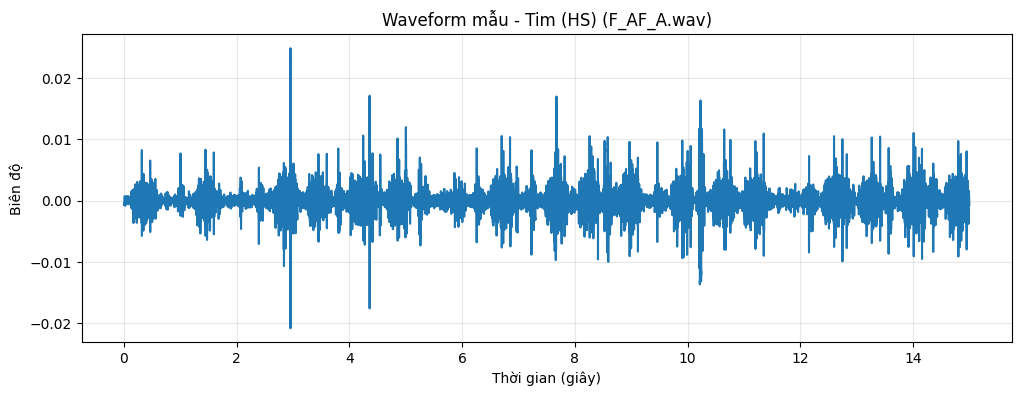

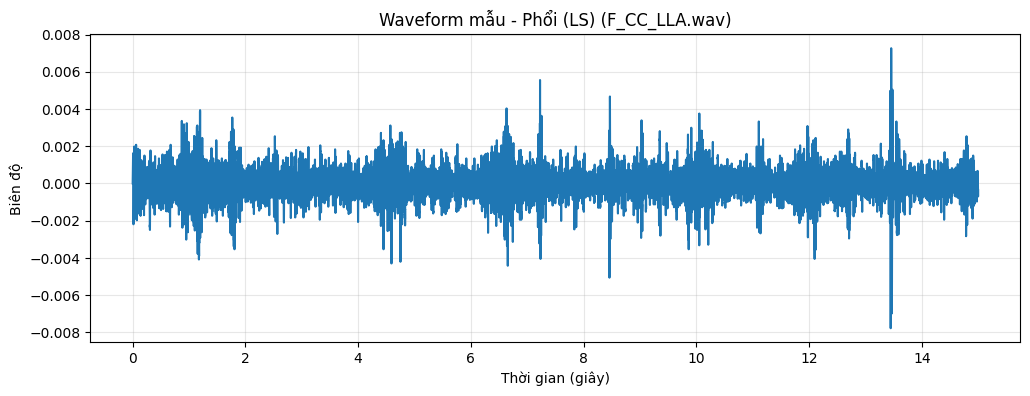

In [8]:
# Vẽ waveform mẫu
def ve_waveform(path_wav: Path, tieu_de: str): 
    y, sr = librosa.load(path_wav, sr=None) 

    thoi_gian = np.arange(len(y)) / sr 

    plt.figure(figsize=(12, 4))  
    plt.plot(thoi_gian, y)  
    plt.title(tieu_de)  
    plt.xlabel('Thời gian (giây)')  
    plt.ylabel('Biên độ')  
    plt.grid(alpha=0.3)  
    plt.show()  

ve_waveform(wav_mau_hs, f'Waveform mẫu - Tim (HS) ({wav_mau_hs.name})') 
ve_waveform(wav_mau_ls, f'Waveform mẫu - Phổi (LS) ({wav_mau_ls.name})')  

| Tiêu chí         | Âm tim (HS) | Âm phổi (LS) |
| ---------------- | ----------- | ------------ |
| Biên độ          | Cao         | Thấp         |
| Spike            | Nhiều       | Ít           |
| Chu kỳ           | Rõ          | Không rõ     |

spike : một xung biên độ lớn xuất hiện đột ngột trong thời gian rất ngắn


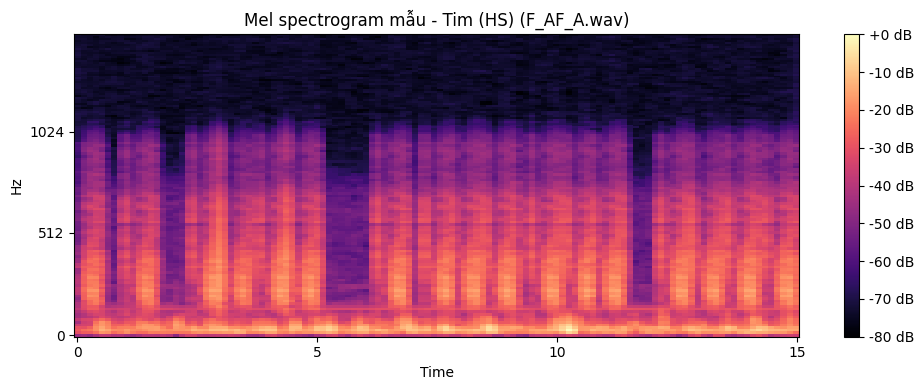

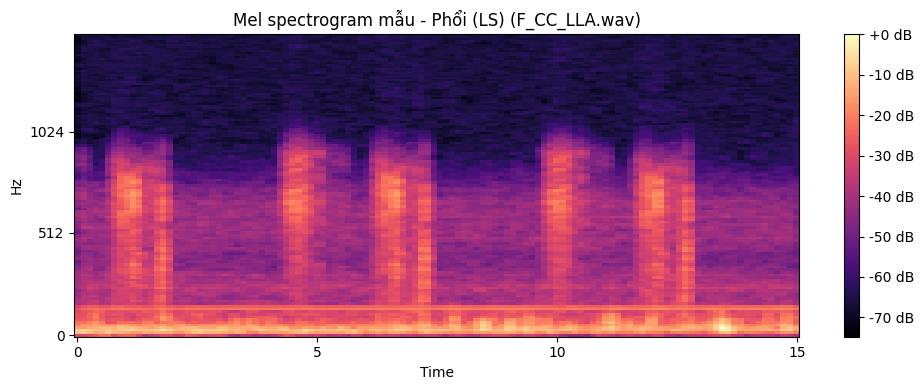

In [9]:
# Vẽ Mel spectrogram mẫu
def ve_mel_spectrogram(path_wav: Path, tieu_de: str, so_mel: int = 128):  
    y, sr = librosa.load(path_wav, sr=None)  
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=so_mel)  
    S_db = librosa.power_to_db(S, ref=np.max)  

    plt.figure(figsize=(10, 4))  
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')  
    plt.colorbar(format='%+2.0f dB')  
    plt.title(tieu_de)  
    plt.tight_layout()  
    plt.show()  

ve_mel_spectrogram(wav_mau_hs, f'Mel spectrogram mẫu - Tim (HS) ({wav_mau_hs.name})')  
ve_mel_spectrogram(wav_mau_ls, f'Mel spectrogram mẫu - Phổi (LS) ({wav_mau_ls.name})')  

Âm tim năng lượng tập trung mạnh ở dải tần thấp:

- Chủ yếu < 150–200 Hz

- Xuất hiện các cột năng lượng thẳng đứng, lặp lại đều theo thời gian

- Khoảng cách giữa các cột khá đều -> nhịp tim ổn định

Có thành phần năng lượng lan lên tần số cao hơn (~500–1000 Hz) nhưng:

- Cường độ giảm dần

- Không kéo dài liên tục

Các cột thẳng đứng tương ứng S1 – S2

Năng lượng thấp tần chiếm ưu thế là đặc trưng của âm tim

Âm phổi năng lượng phân bố rộng hơn theo tần số

- Trải từ ~100 Hz đến >1000 Hz

- Xuất hiện các vùng sáng theo từng pha hô hấp

- Không đều chu kỳ như tim

Không thấy:

- Các vệt mảnh, kéo dài, sáng mạnh ở tần số cao

- Các burst ngắn, dày đặc, lặp lại nhanh

## 5. Tiền xử lý WAV

In [10]:
# Thiết lập tham số chuẩn
tan_so_mau = 4000  
do_dai_giay = 5 
so_mel = 128  

print('Tham số tiền xử lý:')  
print('- Tần số mẫu:', tan_so_mau)  
print('- Độ dài chuẩn (giây):', do_dai_giay)  
print('- Số Mel bands:', so_mel)  

Tham số tiền xử lý:
- Tần số mẫu: 4000
- Độ dài chuẩn (giây): 5
- Số Mel bands: 128


In [11]:
# Hàm tiền xử lý 1 file WAV
def tien_xu_ly_wav(path_wav: Path, tan_so_mau: int, do_dai_giay: int, so_mel: int):  
    y, sr = librosa.load(path_wav, sr=tan_so_mau) 

    do_dai_muc_tieu = tan_so_mau * do_dai_giay  
    if len(y) < do_dai_muc_tieu: 
        y = np.pad(y, (0, do_dai_muc_tieu - len(y)))  
    else:  
        y = y[:do_dai_muc_tieu] 

    S = librosa.feature.melspectrogram(y=y, sr=tan_so_mau, n_mels=so_mel)  
    S_db = librosa.power_to_db(S, ref=np.max)  

    return S_db  

In [12]:
# Hàm xử lý cả thư mục
def tien_xu_ly_thu_muc(ds_wav, nhan: int):
    X = []
    y = []

    for p in ds_wav:
        try:
            mel = tien_xu_ly_wav(p, tan_so_mau, do_dai_giay, so_mel)
            X.append(mel)
            y.append(nhan)
        except Exception as e:
            print(f'Lỗi khi xử lý {p.name}: {e}')

    return np.array(X), np.array(y)


X_hs, y_hs = tien_xu_ly_thu_muc(ds_hs, nhan=0)
X_ls, y_ls = tien_xu_ly_thu_muc(ds_ls, nhan=1)

print('HS:', X_hs.shape, y_hs.shape)
print('LS:', X_ls.shape, y_ls.shape)

HS: (50, 128, 40) (50,)
LS: (50, 128, 40) (50,)


## 6. Lưu Mel spectrogram thành ảnh

In [13]:
# Tạo thư mục lưu ảnh
thu_muc_anh_mel = thu_muc_du_lieu / 'mel_images'  
(thu_muc_anh_mel / 'HS').mkdir(parents=True, exist_ok=True)  
(thu_muc_anh_mel / 'LS').mkdir(parents=True, exist_ok=True)  

print('Thư mục lưu ảnh Mel:', thu_muc_anh_mel) 

Thư mục lưu ảnh Mel: Dataset.v2\mel_images


In [14]:
# Hàm lưu 1 Mel spectrogram thành PNG
def luu_mel_anh(mel_db: np.ndarray, path_png: Path):
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(mel_db, aspect='auto', origin='lower', cmap='magma')
    plt.savefig(path_png, bbox_inches='tight', pad_inches=0)
    plt.close()

In [15]:
# Lặp qua tất cả file WAV để lưu ảnh HS và LS
so_loi = 0

for p in ds_hs:
    try:
        mel = tien_xu_ly_wav(p, tan_so_mau, do_dai_giay, so_mel)
        duong_dan_luu = thu_muc_anh_mel / 'HS' / f'{p.stem}.png'
        luu_mel_anh(mel, duong_dan_luu)
    except Exception as e:
        so_loi += 1
        print(f'Lỗi lưu ảnh HS {p.name}: {e}')

for p in ds_ls:
    try:
        mel = tien_xu_ly_wav(p, tan_so_mau, do_dai_giay, so_mel)
        duong_dan_luu = thu_muc_anh_mel / 'LS' / f'{p.stem}.png'
        luu_mel_anh(mel, duong_dan_luu)
    except Exception as e:
        so_loi += 1
        print(f'Lỗi lưu ảnh LS {p.name}: {e}')

print('Hoàn tất lưu ảnh Mel. Số lỗi:', so_loi)

Hoàn tất lưu ảnh Mel. Số lỗi: 0


## 7. Load ảnh Mel spectrogram cho CNN

In [16]:
# Hàm load ảnh từ thư mục và gán nhãn
def load_anh_tu_thu_muc(thu_muc: Path, nhan: int, img_size=(128, 128)):
    X = []
    y = []

    for ten_file in os.listdir(thu_muc):
        if not ten_file.lower().endswith('.png'):
            continue

        path_anh = thu_muc / ten_file
        img = load_img(path_anh, target_size=img_size, color_mode='rgb')
        img_arr = img_to_array(img) / 255.0

        X.append(img_arr)
        y.append(nhan)

    return X, y


img_size = (128, 128)

X_hs_img, y_hs_img = load_anh_tu_thu_muc(thu_muc_anh_mel / 'HS', nhan=0, img_size=img_size)
X_ls_img, y_ls_img = load_anh_tu_thu_muc(thu_muc_anh_mel / 'LS', nhan=1, img_size=img_size)

X = np.array(X_hs_img + X_ls_img)
y = np.array(y_hs_img + y_ls_img)

print('Shape X:', X.shape)
print('Shape y:', y.shape)
print('Phân bố nhãn:', pd.Series(y).value_counts().to_dict())

Shape X: (100, 128, 128, 3)
Shape y: (100,)
Phân bố nhãn: {0: 50, 1: 50}


## 8. Chia train/validation và lưu thành thư mục chuẩn

In [17]:
# Chia train/validation có stratify
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=SEED,
    stratify=y
)

print('Train:', X_train.shape, y_train.shape)
print('Val  :', X_val.shape, y_val.shape)

Train: (70, 128, 128, 3) (70,)
Val  : (30, 128, 128, 3) (30,)
